# Classification Exercise - MNIST Number Data

**Table of Contents**

* [Libraries & Data Import](#Import-libraries-&-MNIST-data-from-Scikit-Learn)
* [Data Analysis](#Data-Analysis)
* [Train a Binary Classifier](#Train-a-Binary-Classifier)
* [Performance Measures](#Performance-Measures)
* [Multiclass Classification (In Progress)](#Multiclass-Classification)

## Import libraries & MNIST data from Scikit-Learn

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import warnings
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X,y=mnist['data'],mnist['target']

In [4]:
print(X.shape,y.shape)

(70000, 784) (70000,)


## Data Analysis

We can look at how the 784-featured array would look like visually by looking at a single data point. It can be reshaped into a 28x28 square matrix and then plotted using the matplot binary mapping.

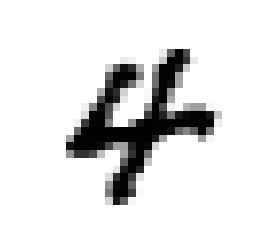

In [5]:
some_digit=X[27553]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

It appears to be the number 5. It can be confirmed by looking at the target value at the corresponding data point.

In [6]:
y[27553]

4.0

The 70000 datapoints can be split into a 60000 training set and 10000 test set as follows. We will also shuffle the training data to ensure that we get the fairest training model (make sure to shuffle so that you don't end up having too many of the same digits and too few of the others.)

In [7]:
Xtrain,Xtest,ytrain,ytest=X[:60000],X[60000:],y[:60000],y[60000:]

In [8]:
shuffle_index=np.random.permutation(60000)
Xtrain,ytrain=Xtrain[shuffle_index],ytrain[shuffle_index]

## Train a Binary Classifier

We are going to train a binary classifier on a single number, say 4. We will use this to prove why accuracy may not be the best performance metric in this situation. 

The classifier model used will be Stochastic Gradient Descent. SGD has the advantage of being capable of handling very larget datasets efficiently (because it handles training instances independently; it's well suited for online learning).

In [9]:
ytrain_4 = (ytrain==4)
ytest_4 = (ytest==4)

from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(Xtrain,ytrain_4)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

The SGD classifier was fit to predict true for all 4's and false for otherwise. Since our single data point *some_digit* was 4, it was predicted to be true. (It guessed correctly) 

## Performance Measures

### 1. Accuracy

Now we can measure how well SGD does by using cross-validation.

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,Xtrain,ytrain_4,cv=3,scoring="accuracy")

array([ 0.97935103,  0.9739    ,  0.9780989 ])

The tests show over 95% accuracy. But is the SGD really that much accurate? To prove not so, we will test the other side; the model to test whether a number is **not** 4.

In [12]:
from sklearn.base import BaseEstimator

class Never4Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
never4_clf = Never4Classifier()
cross_val_score(never4_clf,Xtrain,ytrain_4,cv=3,scoring='accuracy')

array([ 0.90265,  0.90065,  0.9046 ])

The accuracy of predicting a "not 4" is still over 90%. Why is this true? Because the data is pretty balanced in terms of how many each digit is represented. Therefore, there are about 90% of the whole data that are *not 4*. So even with a simple classifier that predicts not 4 for all dataset, it will be at 90% accurate. 

This tells us that Accuracy is not necessarily the best performance measurement for classifiers **especially with skewed dataset**.

### 2. Confusion Matrix

Instead, we can evaluate using the *confusion matrix*. Confusion matrix is a matrix that shows the number of instances in which an instance "A" was classified as instance "B". For example in our dataset, if a model predicts a "5" as a "3", we would look at the 5th row and 3rd column of the confusion matrix and see that prediction tallied.

We will run a SGD in cross validation and then produce a confusion matrix based on our data.


In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

ytrain_pred=cross_val_predict(sgd_clf,Xtrain,ytrain_4,cv=3)
confusion_matrix(ytrain_4,ytrain_pred)

array([[53500,   658],
       [  715,  5127]])

The matrix tells us the following:
* 53205 of the non-4's were predicted as a non-4 (*True Negative*)
* 953 of the non-4's were incorrectly predicted as a 4 (*False Positive*)
* 504 of the 4's were incorrectly predicted as a non-4 (*False Negative*)
* 5338 of the 4's were predicted as a 4 (*True Positive*)

Based on the confusion matrix, we derive two basic metrics: *precision* and *recall*. 

* Precision measures the accuracy of the positive predictions: $$Precision = \frac{TP}{TP+FP}$$
* Recall measures the ratio of positives that are correctly detected: $$Recall = \frac{TP}{TP+FN}$$

### 3. Precision/Recall

Now we can implement the Precision and Recall to see some more suitable metrics for the SGD.

In [14]:
from sklearn.metrics import precision_score, recall_score
print("Precision: ", precision_score(ytrain_4,ytrain_pred))
print("Recall: ", recall_score(ytrain_4,ytrain_pred))

Precision:  0.886257562662
Recall:  0.877610407395


In [15]:
print("Precision by hand: ", 5338/(5338+953))
print("Recall by hand: ", 5338/(5338+504))

Precision by hand:  0.8485137498013035
Recall by hand:  0.9137281752824375


The new metrics show that the classifier is only 91% accurate predicting the digit 4 correctly, and 84% correct when it predicts a digit as a 4 (well below 97% measured in pure accuracy). 

It is often convenient to combine *Precision* and *Recall* into a single metric called *F1 score*. *F1 score* is the harmonic mean of precision and recall: 
$$F_1 = \frac{2*precision*recall}{precision+recall} =\frac{TP}{TP+\frac{FN+FP}{2}}$$

We can implement the F1 score using the sklearn function:

In [16]:
from sklearn.metrics import f1_score
f1_score(ytrain_4,ytrain_pred)

0.88191278919755733

The classifier makes the decision based on something called *decision threshold*. Depending on how you adjust the threshold, the precision and recall may change. We can examine this using the decision_function.

In [17]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([ 178120.61321343])

In [18]:
threshold=0
y_some_digit_pred =(y_scores>threshold)
print(y_some_digit_pred)

threshold=200000
y_some_digit_pred=(y_scores > threshold)
print(y_some_digit_pred)

[ True]
[False]


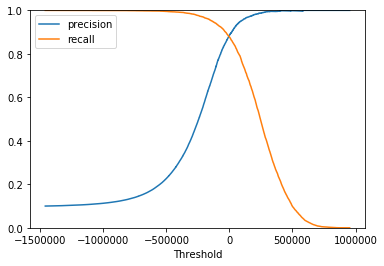

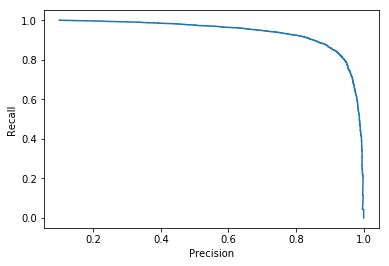

In [23]:
y_scores=cross_val_predict(sgd_clf,Xtrain,ytrain_4,cv=3,method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(ytrain_4,y_scores)

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    ys=[precisions[1:],recalls[1:]]
    labels=['precision','recall']
    for y,label in zip(ys,labels):
        plt.plot(thresholds,y,label=label)
    plt.xlabel('Threshold')
    plt.legend(loc="upper left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()
plt.plot(precisions,recalls)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()


We can determine the threshold based on where we want the precision/recall to be. Suppose we want 90% precision, then we will need to use approximately 70000 as threshold value.

In [23]:
y_train_pred_90 = (y_scores > 70000)
precision_score(ytrain_4,y_train_pred_90)

0.93248780487804883

In [25]:
recall_score(ytrain_4,y_train_pred_90)

0.81804176651831562

### 4. ROC Curve

ROC Curve (Receiver Operating characteristic curve) is another common tool used with binary classifiers. It plots the *true positive rate* (or recall or sensitivity) against *false positive rate* (or specificity), which is the ratio of negative instances that are *incorrectly* classified as positive.

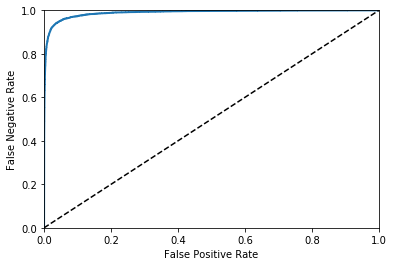

In [30]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(ytrain_4,y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative Rate')
    
plot_roc_curve(fpr,tpr)
plt.show()

The graph shows that higher the recall, higher the specificity. We can also measure the area under the curve (AUC).

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytrain_4,y_scores)

0.98874327463563161

As far as what to use between Precision/Recall and the ROC curve: P/R is better when there are very little positive class or you care more about the false positives than false negatives. ROC curve would be preferable otherwise.'

Now knowing the ROC and the AUC score, we can compare another classifier with the SGD. We will use a RandomForestClassifier. Random Forest does NOT have a *decision_function()*; instead we will use *predict_proba()* method.

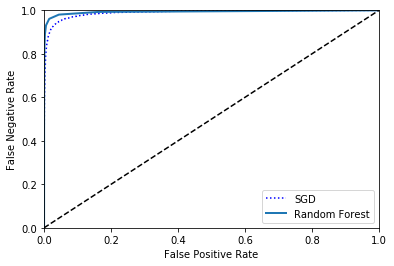

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_forest=cross_val_predict(forest_clf,Xtrain,ytrain_4,cv=3,method='predict_proba')

y_scores_forest=y_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest=roc_curve(ytrain_4,y_scores_forest)

plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

Now you can see that the RandomForestClassifier ROC curve looks much better. We can confirm this by looking at the ROC AUC score:

In [35]:
roc_auc_score(ytrain_4,y_scores_forest)

0.99320772317961614

## Multiclass Classification